# Train and test split + Copying images into train and test folders

## 1. Reload images dataset

In [154]:
import pandas as pd

images_dataset_path = 'data/datasets/images.csv'
df_images = pd.read_csv(images_dataset_path)

split_dataset_path = 'data/splits/sgkf-8-1-1/images.csv'
df_split = pd.read_csv(split_dataset_path, index_col=0)

display(df_images.columns)
display(df_images.index[:10])
print()
display(df_split.columns)
display(df_split.index[:10])

Index(['id_video', 'code', 'folder', 'file_name', 'file_path', 'frame_index',
       'timestamp', 'initial_timestamp', 'seen', 'tags'],
      dtype='object')

RangeIndex(start=0, stop=10, step=1)

Index(['id_video', 'code', 'folder', 'file_name', 'file_path', 'frame_index',
       'timestamp', 'initial_timestamp', 'seen', 'tags', 'tag', 'flood',
       'set'],
      dtype='object')

Index([151149, 55823, 14423, 70564, 166171, 111526, 101842, 107063, 119478,
       80400],
      dtype='int64')

## 2. Preprocess the dataset

In [155]:
from modules.octa_video_util import _assign_tag
from modules.octa_video_util import filter_by_query

#### Convert datetime fields

In [157]:
df_images['timestamp'] = pd.to_datetime(df_images['timestamp'])
df_images['initial_timestamp'] = pd.to_datetime(df_images['initial_timestamp'])

df_split['timestamp'] = pd.to_datetime(df_split['timestamp'])
df_split['initial_timestamp'] = pd.to_datetime(df_split['initial_timestamp'])

#### Create categorical field from tag priority list

In [159]:
# Create unique tag column based on class priority list
default_tag = 'normal'
tags_priority_list = ['alagamento', 'bolsão', 'lâmina', 'poça', 'transbordo']

df_images['tag'] = df_images['tags'].apply(lambda tags_list: _assign_tag(tags_list, tags_priority_list, default_tag))
display(df_images.tag.value_counts())

tag
normal        100783
poça           58101
lâmina          5488
alagamento      3150
transbordo      2237
bolsão          1246
Name: count, dtype: int64

#### Drop categories

In [160]:
df_images = df_images[df_images['tag'] != 'transbordo']

#### Binarize categorical variable

In [161]:
target_classes = ['lâmina', 'bolsão', 'alagamento']

# Binarize categorical variable from list of target classes
df_images['flood'] = df_images['tag'].isin(target_classes).astype(int)

display(df_images['flood'].value_counts())
print()
display(df_images.index[:10])

C:\Users\luisr\AppData\Local\Temp\ipykernel_6848\3272987754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_images['flood'] = df_images['tag'].isin(target_classes).astype(int)


flood
0    158884
1      9884
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

#### Filter images

In [162]:
query_params = {'seen': True}

# Filter dataset of images by query
df_sample = filter_by_query(df_images, query_params).copy()

display(df_sample['flood'].value_counts())
print()
display(df_sample.index[:10])

flood
0    158884
1      9884
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

---
## 3. Data Exploration

#### Distribution of number of images in videos

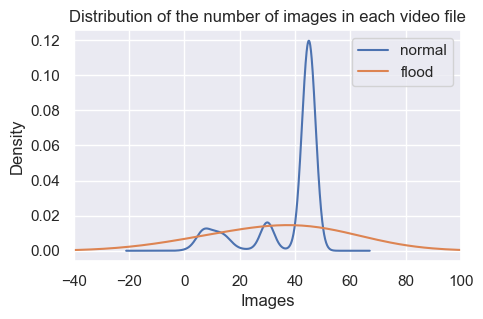

In [163]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
ax = df_sample[df_sample['flood'] == 0]['id_video'].value_counts().plot.kde(label='normal')
ax = df_sample[df_sample['flood'] == 1]['id_video'].value_counts().plot.kde(ax=ax, label='flood')

ax.set(
    title='Distribution of the number of images in each video file',
    xlabel='Images',
    xlim=(-40, 100),
)
ax.legend()
plt.show()

#### Sun Time distribution

In [28]:
# !pip install astral

sun time min: 06:05:46
sun time max: 18:30:01.600000
night time min: 00:00:00
night time max: 23:55:46.600000

Samples at sum time without flood: 46.83 %
Samples  at sum time with flood: 73.52 %


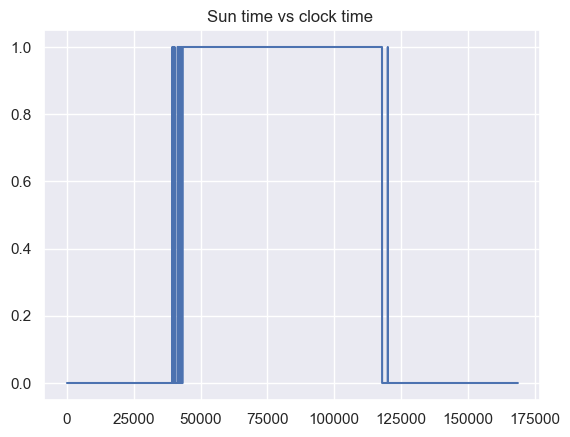

In [89]:
import pandas as pd
from astral.sun import sun
from astral import Observer
import pytz

# Define Rio de Janeiro coordinates
rio_lat = -22.9068
rio_lon = -43.1729

# Create an Observer object for Rio de Janeiro
rio_observer = Observer(rio_lat, rio_lon)

# Function to determine if it's sun time in Rio de Janeiro
def is_sun_time(dt):
    # Convert timestamp to Rio de Janeiro timezone
    dt_rio = dt.tz_localize(pytz.timezone('America/Sao_Paulo'))

    # Calculate sunrise and sunset times for Rio de Janeiro on the given date
    s = sun(rio_observer, date=dt_rio.date())
    
    # Convert sunrise and sunset times to Rio de Janeiro timezone
    sunrise_rio = s['sunrise'].astimezone(pytz.timezone('America/Sao_Paulo'))
    sunset_rio = s['sunset'].astimezone(pytz.timezone('America/Sao_Paulo'))

    # Check if the given datetime falls between sunrise and sunset
    return sunrise_rio <= dt_rio <= sunset_rio

# Apply the function to the 'timestamp' column to get boolean values
df_sample['sun_time'] = df_sample['timestamp'].apply(is_sun_time)

sun_time_times = df_sample[df_sample['sun_time']]['timestamp'].dt.time
night_time_times = df_sample[~df_sample['sun_time']]['timestamp'].dt.time
print('sun time min:', sun_time_times.min())
print('sun time max:', sun_time_times.max())
print('night time min:', night_time_times.min())
print('night time max:', night_time_times.max())
print()

samples_not_flood_sun_time = round(sun_time_series[df_sample['flood']==0].mean() * 100, 2)
samples_flood_sun_time = round(sun_time_series[df_sample['flood']==1].mean() * 100, 2)
print('Samples at sum time without flood:', samples_not_flood_sun_time, '%')
print('Samples  at sum time with flood:', samples_flood_sun_time, '%')

ax = df_sample['sun_time'].astype(int).loc[df_sample['timestamp'].dt.time.sort_values().index].reset_index(drop=True).plot(title="Sun time vs clock time")


#### Group undersampler

In [202]:
import numpy as np

def group_even_undersample(x, y, groups, prct=0.5, n=None, random_state=None):
    group_cnt = groups.value_counts()
    if n is None:
        n = int(np.percentile(group_cnt, prct * 100))
    index = []
    for group in group_cnt.index:
        index += y[groups == group].sample(min(n, group_cnt[group]), replace=False, random_state=random_state).index.tolist()
    return x.loc[index], y.loc[index]

#### Undersample single class evenly

In [228]:
subsample_index = []

class_df = df_sample[df_sample['tag'] == 'poça']

x_cls = class_df.drop('flood', axis=1)
y_cls = class_df['flood']
groups_cls = class_df['code']
x_cls_res, y_cls_res = group_even_undersample(x_cls, y_cls, groups_cls, n=54, random_state=0)

subsample_index += y_cls_res.index.tolist()
# len(y_cls_res)

class_df = df_sample[df_sample['tag'] == 'normal']

x_cls = class_df.drop('flood', axis=1)
y_cls = class_df['flood']
groups_cls = class_df['code']
x_cls_res, y_cls_res = group_even_undersample(x_cls, y_cls, groups_cls, n=37, random_state=0)

subsample_index += y_cls_res.index.tolist()
# len(y_cls_res)

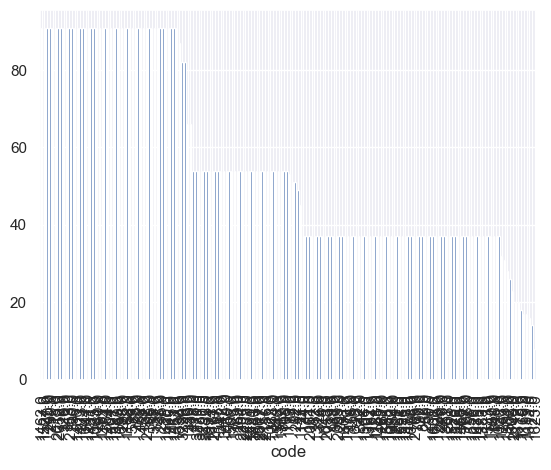

In [233]:
majority_samples = df_sample.loc[subsample_index]

ax = majority_samples['code'].value_counts().plot.bar()

In [236]:
class_df = df_sample[df_sample['flood'] == 1.0]

x_cls = class_df.drop('flood', axis=1)
y_cls = class_df['flood']
groups_cls = class_df['code']
x_cls_res, y_cls_res = group_even_undersample(x_cls, y_cls, groups_cls, n=1000, random_state=0)

subsample_index = y_cls_res.index.tolist()

len(subsample_index)

9759

#### Camera distribution

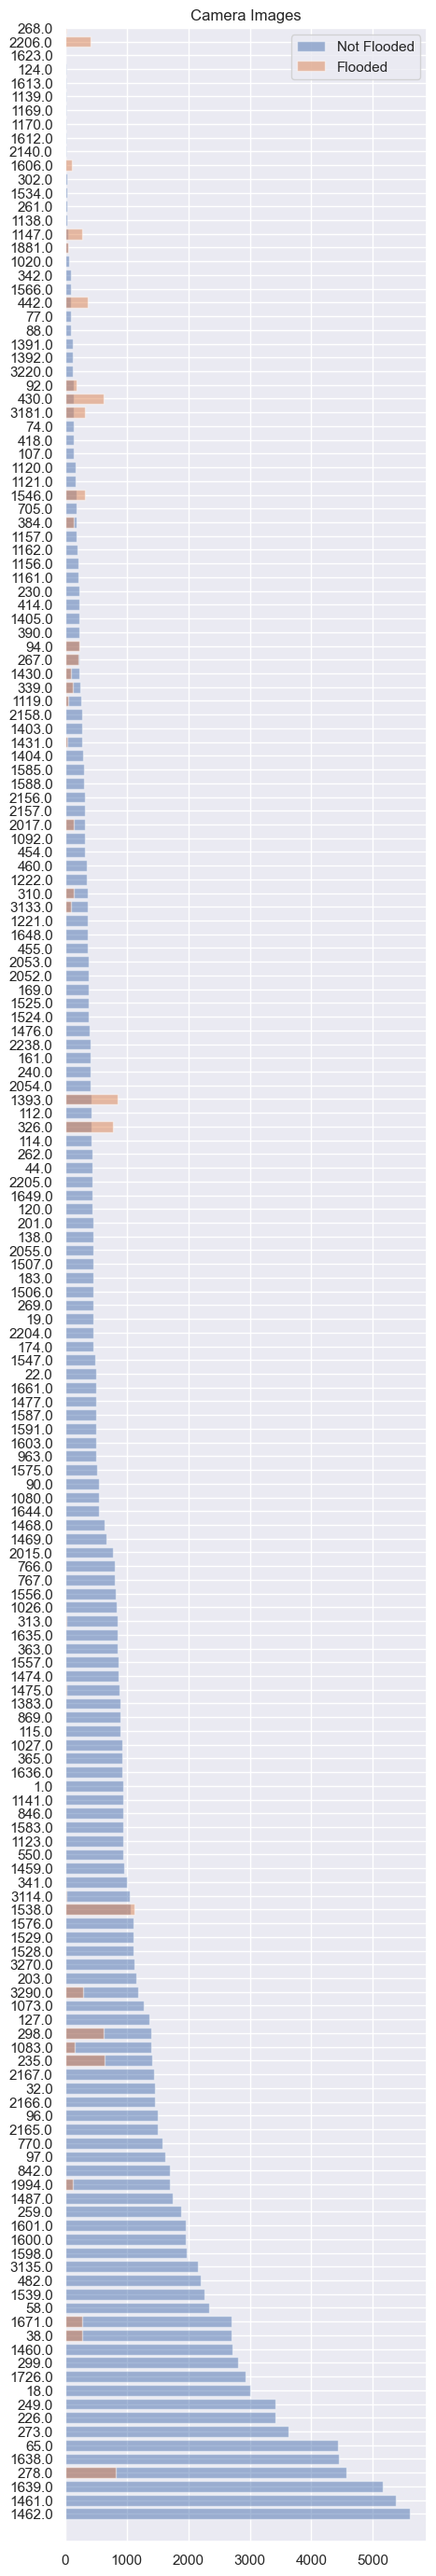

In [140]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 35))

cnt_0 = df_sample[df_sample['flood'] == 0]['code'].value_counts()
cnt_1 = df_sample[df_sample['flood'] == 1]['code'].value_counts()

# Plot bars with transparency
plt.barh(cnt_0.index.astype(str), cnt_0.values, alpha=0.5, label='Not Flooded')  # Set transparency to 0.5
plt.barh(cnt_1.index.astype(str), cnt_1.values, alpha=0.5, label='Flooded')  # Set transparency to 0.5

plt.title('Camera Images')
plt.legend()  # Show legend
plt.ylim(-2, len(cnt_0) + 1)

plt.show()


Cameras in positive images: 34


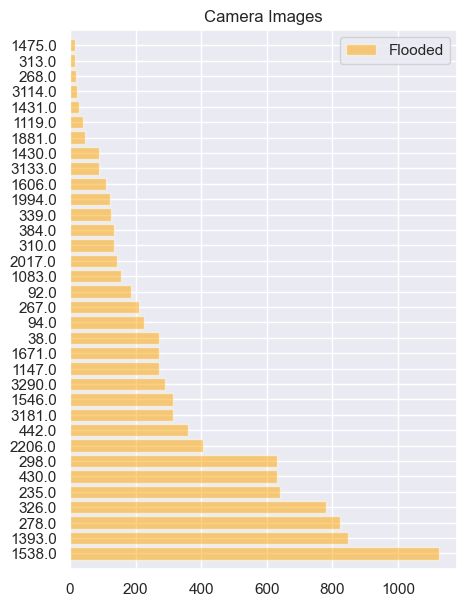

In [169]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 7))

cnt_1 = df_sample[df_sample['flood'] == 1]['code'].value_counts()
print('Cameras in positive images:', len(cnt_1))

# Plot bars with transparency
plt.barh(cnt_1.index.astype(str), cnt_1.values, alpha=0.5, label='Flooded', color='orange')  # Set transparency to 0.5

plt.title('Camera Images')
plt.legend()  # Show legend
plt.ylim(-1, len(cnt_1))

plt.show()


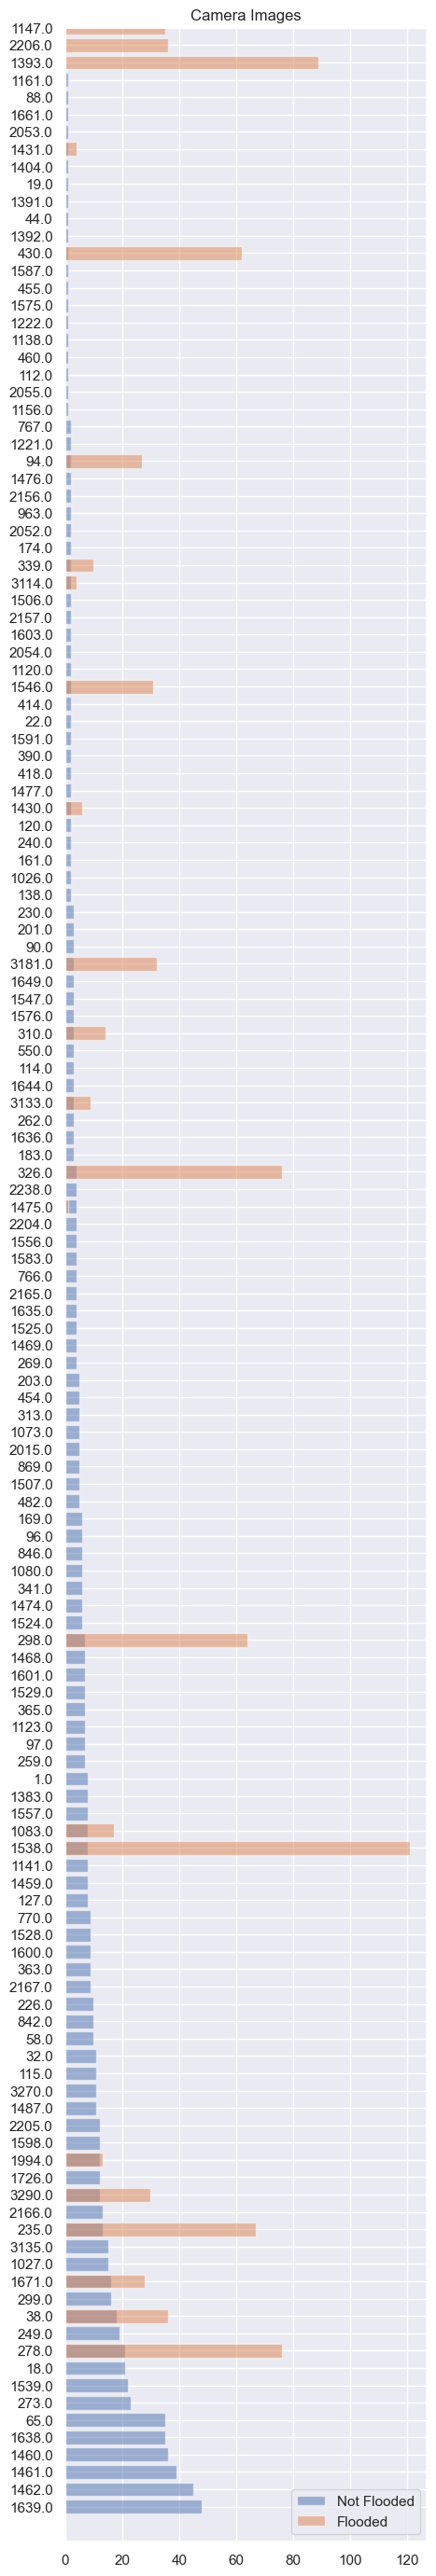

In [170]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 35))

cnt_0 = df_split[df_split['flood'] == 0]['code'].value_counts()
cnt_1 = df_split[df_split['flood'] == 1]['code'].value_counts()

# Plot bars with transparency
plt.barh(cnt_0.index.astype(str), cnt_0.values, alpha=0.5, label='Not Flooded')  # Set transparency to 0.5
plt.barh(cnt_1.index.astype(str), cnt_1.values, alpha=0.5, label='Flooded')  # Set transparency to 0.5

plt.title('Camera Images')
plt.legend()  # Show legend
plt.ylim(-2, len(cnt_0) + 2)

plt.show()


Cameras in positive samples: 33


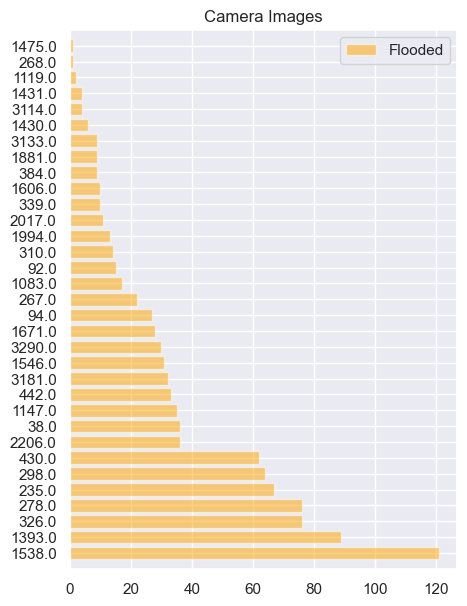

In [168]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 7))

cnt_1 = df_split[df_split['flood'] == 1]['code'].value_counts()
print('Cameras in positive samples:', len(cnt_1))

# Plot bars with transparency
plt.barh(cnt_1.index.astype(str), cnt_1.values, alpha=0.5, label='Flooded', color='orange')  # Set transparency to 0.5

plt.title('Camera Images')
plt.legend()  # Show legend
plt.ylim(-1, len(cnt_1))

plt.show()
